In [1]:
import sys,os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as mb
from lsst.sims.utils import Site
from lsst.sims.utils import calcLmstLast

In [3]:
o = db.OpsimDatabase(os.path.expanduser('~/Data/db/colossus_2296.db'))

In [4]:
# Query fields from WFD
sql_query = '''select * from Field join ProposalField on 
Field.fieldId == ProposalField.Field_fieldId 
where ProposalField.Proposal_propId == 3
'''
d = o.query_arbitrary(sql_query)

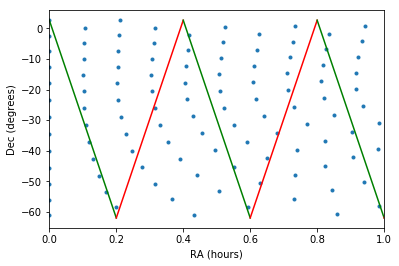

In [5]:
plt.plot(d['ra']*12./180,d['dec'],'.')
xx = np.array([0.,12./60.])
yy = np.array([np.min(d['dec']), np.max(d['dec'])])

for i in range(40):
    if i%2:
        xx = np.array([i*12./60,(i+1)*12./60.])
        plt.plot(xx,yy,'r-')
    else:
        xx = np.array([(i+1)*12./60.,i*12./60])
        plt.plot(xx,yy,'g-')
        

plt.xlim(0,1)
#plt.ylim(-60,-50)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')


(array([ 131.,  157.,  192.,  218.,  225.,  263.,  267.,  257.,  295.,  288.]),
 array([-62.021178 , -55.5502558, -49.0793336, -42.6084114, -36.1374892,
        -29.666567 , -23.1956448, -16.7247226, -10.2538004,  -3.7828782,
          2.688044 ]),
 <a list of 10 Patch objects>)

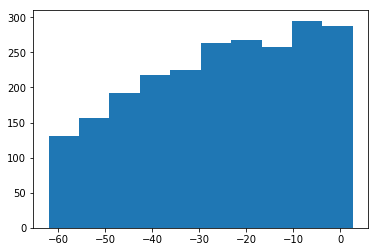

In [6]:
plt.hist(d['dec'])

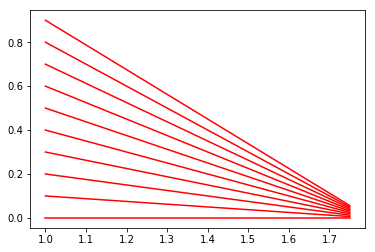

In [7]:
max_am = 1.8
am = np.arange(1.0, max_am, 0.05)

for am_bonus in np.arange(0., 1.0, 0.1):
    mar = am_bonus * (max_am - am) / (max_am - 1.0)
    plt.plot(am, mar, 'r-')


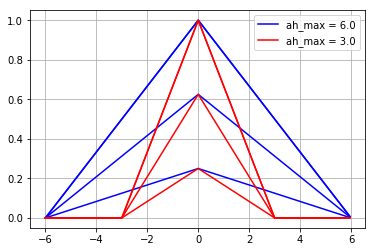

In [8]:
max_ah = 6.0
ah = np.arange(-6.0, 6.0, 0.05)
ah_bonus = 1.0

for ah_bonus in np.linspace(0.25, 1.0, 3):
#     ahr = ah_bonus * np.exp(-(3*np.abs(ah) / max_ah)**2.)
#     ahr = ah_bonus * np.exp(-(3*np.abs(ah) / max_ah)**2.)
#     plt.plot(ah, ahr, 'b-')
    ahr = ah_bonus * (1-np.abs(ah) / max_ah)
    plt.plot(ah, ahr, 'b-')
plt.plot(ah, ahr, 'b-',label='ah_max = %.1f' % max_ah)

max_ah = 3.0
for ah_bonus in np.linspace(0.25, 1.0, 3):
#     ahr = ah_bonus * np.sqrt(1-np.abs(ah) / max_ah)
#     ahr[np.abs(ah) > max_ah] = 0.
#     plt.plot(ah, ahr, 'r-')
    
    ahr = ah_bonus * (1-np.abs(ah) / max_ah)
    ahr[np.abs(ah) > max_ah] = 0.
    plt.plot(ah, ahr, 'r-')
plt.plot(ah, ahr, 'r-',label='ah_max = %.1f' % max_ah)

plt.legend()
plt.grid()

In [9]:
# o = db.OpsimDatabase('db/colossus_2195.db')
propids, proptags = o.fetchPropInfo()
#wfdfields = o.fetchFieldsFromFieldTable(proptags['WFD'])
#wfdWhere = o.createSQLWhere('WFD', proptags)

In [10]:
# Pick a night
night = 1
d = o.query_columns('SummaryAllProps', colnames=['observationId', 'night', 
                                                 'observationStartMJD', 'observationStartLST', 'fieldRA', 
                                                 'fieldDec',
                                                 'filter'], 
                    sqlconstraint='night <= %i' % (night))
tnow = d['observationStartMJD'][0]

In [11]:
lsstSite = Site('LSST')

In [12]:
s = slicers.HealpixSlicer(nside=32)
ra = s.slicePoints['ra']
dec = s.slicePoints['dec']
tnow = 59580.0
alt, az = stackers.raDec2AltAz(ra, dec, lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
lmst, last = calcLmstLast(tnow, lsstSite.longitude_rad)
lmst_deg = lmst / 24.0 * 360.0
print('LMST', lmst, 'hrs', lmst_deg, 'deg')
azmask = np.where(alt<0, True, False)
hour_angle = lmst - np.degrees(ra)*12./180.
hour_angle[hour_angle < 24.] += 24.
hour_angle[hour_angle > 24.] -= 24.
hour_angle[hour_angle > 12] -= 24

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
LMST 1.99204240346 hrs 29.8806360519 deg


1

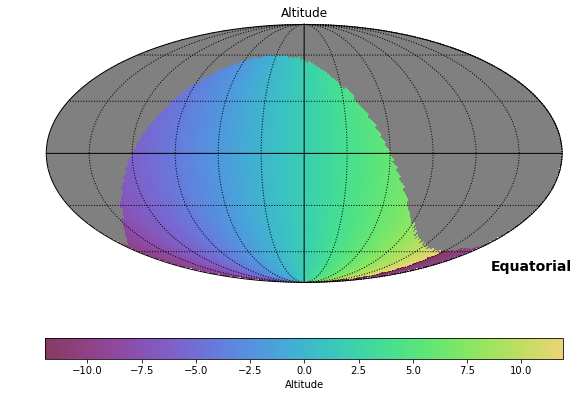

In [13]:
val = ma.MaskedArray(data=hour_angle, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Altitude', 'xlabel': 'Altitude'}
plots.HealpixSkyMap()(val, s, plotDict)